## Данные

В качестве основной задачи выбрал определение спама в SMS, на основе датасета по [ссылке](https://huggingface.co/datasets/AbdulHadi806/mail_spam_ham_dataset) (лицензия: MIT, разрешает как исследовательское, так и коммерческое использование). Задача имеет несбалансированную природу классов: около 14% таргетного бинарного класса в иходном датасете, и 12-13% -- после дедубликации.

Для увеличения количества данных взял данные из Enron-Spam тест-сета. Этот датасет сбалансирован по классам, но является Out-Of-Domain для поставленной задачи: сообщения из него отправлялись не через SMS, а по электронной почте. У email'ов из данного набора есть дополнительные источники информации такие как тема письма и дата отправления. Эти признаки использоваться не будут.

Также к имеющимся данным добавил сгенерированные gpt2 сообщения наподобие тех, что были в изначальном датасете (без обуславливания на таргетную метку). Для них неизвестны классы, что будет лечиться Semi-Supervised подходом.

В этом же пункте производится простейшая дедубликация всех имеющихся датасетов.

In [1]:
import pandas as pd
from IPython.display import display

df_main = pd.read_csv("hf://datasets/AbdulHadi806/mail_spam_ham_dataset/mail_data.csv")
df_email = pd.read_json("hf://datasets/SetFit/enron_spam/test.jsonl", lines=True)
df_email.pop("message_id")
df_synth = pd.read_csv("SyntheticMessages.csv", index_col=0)

/home/vfyas/trashhh/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
display(df_main.head())
print(df_main.shape)
print((df_main.Category == "spam").mean())

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


(5613, 2)
0.136825227151256


In [3]:
display(df_email.head())
print(df_email.shape)
print(df_email.label.mean())

,text,label,label_text,subject,message,date
0,expande tu imagen ! ! ! ! ! ! ! ! ! si no pued...,1,spam,expande tu imagen ! ! ! ! ! ! ! ! !,"si no puede ver este mail , entre a : http : /...",2005-01-19
1,paliourg learning for life enlarge your member...,1,spam,paliourg learning for life,enlarge your member\nzenextend enlargement pil...,2004-05-06
2,"cure premature ejaculation hello ,\ndid you ej...",1,spam,cure premature ejaculation,"hello ,\ndid you ejaculate before or within a ...",2005-07-17
3,re : noms / actual flow for 3 / 19 / 01 we agr...,0,ham,re : noms / actual flow for 3 / 19 / 01,"we agree\n"" eileen ponton "" on 03 / 20 / 2001 ...",2001-03-20
4,ehronline web address change this message is i...,0,ham,ehronline web address change,this message is intended for ehronline users o...,2001-03-30


(2000, 6)
0.504


In [4]:
display(df_synth.head())
df_synth.shape

,message
0,love this place have been coming here since w...
1,z jus takin dat shiznit fo realz all KNOW dat ...
2,turday and tuesday FA Cup semi final first leg...
3,ve been in the game for long time and know wha...
4,Anonymous Tue AM No not sure what to make of ...


(1085, 1)

In [5]:
df_main.Category = df_main.Category.map({"spam": 1, "ham": 0})

df_email = df_email.loc[:, ["message", "label"]]
df_email.rename(columns={"message": "Message", "label": "Category"}, inplace=True)

df_synth.rename(columns={"message": "Message"}, inplace=True)
df_synth.dropna(inplace=True)
df_synth.loc[:, "Category"] = None

In [6]:
df_main.drop_duplicates(inplace=True)
df_email.drop_duplicates(inplace=True)
df_synth.drop_duplicates(inplace=True)
print(df_main.shape, df_email.shape, df_synth.shape)
print(df_main.Category.mean(), df_email.Category.mean())
print(df_main.Category.isna().sum(), df_email.Category.isna().sum())
print(df_main.Message.isna().sum(), df_email.Message.isna().sum(), df_synth.Message.isna().sum())

(5188, 2) (1954, 2) (943, 2)
0.1281804163454125 0.49488229273285567
0 0
0 0 0


## Метрики

В качестве основной метрики буду использовать Каппу Коэна:
$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Для дополнительной информации о моделях, также буду логировать метрики accuracy, precision, recall, $f_1$, и коэффициент корреляции Мэтьюза:
$$\mathrm{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

In [7]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    matthews_corrcoef,
    cohen_kappa_score,
)
# MAIN: cohen_kappa_score

## Предобработка данных
Простейшая дедубликация и проверка на отсутствующие значения были проведены выше. Для исключения похожих объектов буду использовать нормализованное расстояние Левенштейна: ANLS.

In [8]:
from anls import anls_score
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import numpy as np
from itertools import zip_longest

def find_anls_similar(df_1, df_2=None, thresh=0.85, verbose=False):
    self_filter = False
    if df_2 is None:
        df_2 = df_1
        self_filter = True

    def is_similar_pair(text_1, text_2):
        if abs(len(text_1) - len(text_2)) >= 25:
            return False
        return anls_score(text_1, text_2) >= thresh

    found_indices = []
    first_array = np.array(list(enumerate(df_1.Message.values)))
    second_array = df_2.Message.values if not self_filter else first_array
    first_pbar = tqdm(first_array) if verbose else first_array
    for i, text_1 in first_pbar:
        if self_filter and len(found_indices) > 0 and i in list(zip(*found_indices))[1]:
            continue
        similar_texts = Parallel(n_jobs=-1)(delayed(lambda x: is_similar_pair(text_1, x))(text_2) for j, text_2 in second_array)
        similar_texts = np.array(similar_texts)
        if similar_texts.sum() > 0:
            found_indices.extend(list(zip_longest([i], second_array[similar_texts, 0], fillvalue=i)))
            second_array = second_array[~similar_texts]
            print(len(found_indices))
    return found_indices

In [9]:
df_main["source"] = "main"
df_email["source"] = "email"
df_synth["source"] = "synth"

In [10]:
df_all = pd.concat((df_main, df_email, df_synth), axis=0)
print(df_all.shape[0])
print(df_all.Message.isna().sum())

8085
0


In [11]:
df_all = df_all.loc[df_all.Message.str.len() > 3, :]

In [12]:
print(df_all.loc[:, ["Message"]].duplicated().sum())

0


In [13]:
# similar_indices = find_anls_similar(df_all, verbose=True)

# # краткая история происходящего: он проработал ±5 часов (на 64 ядрах бтв), не нашел дубликатов вообще,
# # я решил оставить так, потому что не самый слабый критерий, можно делать вывод, что всё ок.
# # а потом я как <очень умный человек> решил перезапустить ноут и прогнать всё...
# # моего терпения не хватило ждать пустой список в течение еще 5 часов, поэтому я стопнул.

# len(similar_indices)

In [14]:
print(df_all.shape[0])

8072


## Разбиение датасета на трейн и вал

В качестве валидационной части будет использоваться только часть изначального датасета (SMS), разбиение будет проводиться стратифицированным образом: в трейн и вал попадёт $\approx$одинаковая доля спам-сообщений.

Остальные датасеты будут представлены только в обучении.

In [15]:
from sklearn.model_selection import train_test_split


df_main = df_all.loc[df_all.source == "main"]
df_email = df_all.loc[df_all.source == "email"]
df_synth = df_all.loc[df_all.source == "synth"]


df_main_train, data_val = train_test_split(
    df_main, test_size=0.3,
    stratify=df_main.Category,
    random_state=42
)

In [16]:
df_main_train.Category.mean(), data_val.Category.mean()

(0.12816979051819183, 0.12861736334405144)

In [17]:
df_main_train.shape[0], data_val.shape[0]

(3628, 1555)

In [18]:
data_train = pd.concat((df_main_train, df_email, df_synth), axis=0)
display(data_train.head())
print(data_train.shape[0], data_train.Category.mean(), data_train.Category.isna().mean())

,Category,Message,source
3154,0,I tagged MY friends that you seemed to count a...,main
2639,0,Am in gobi arts college,main
4089,0,He needs to stop going to bed and make with th...,main
1482,0,"I'm a guy, browsin is compulsory",main
4101,0,I not at home now lei...,main


6517 0.2564516129032258 0.14377781187663036


## Преобразования

Из нормализаций предложений буду использовать только исключение мусорных слов, приведение к нижнему регистру и удаление знаков препинания, по двум причинам:
1. Во второй домашке буду юзать трансформеры;
2. Слова все написаны очень непохоже на их оригинальные формы и лемматизации всякие просто бессмысленно пообрубают куски слов, мне такое не нужно,


Далее для создания признаков попробую TfIdf и BoW. Для "аугментаций" буду использовать методы оверсэмплинга (андерсэмплинг не буду использовать, потому что данных не очень много и так).

Утечки были устранены на более раннем этапе, при удалении схожих и дублицирующих объектов

In [19]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/vfyas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
import re
def process_text(s):
    return re.sub(r"[\!\"\#\$\%\&\\\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\]\^\_\`\{\|\}\~]", "", s.lower())

data_train.Message = data_train.Message.apply(process_text)
data_val.Message = data_val.Message.apply(process_text)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [22]:
tf_idf_vec = TfidfVectorizer(min_df=15, stop_words=stopwords.words()).fit(data_train.Message)
bow_vec = CountVectorizer(min_df=15, stop_words=stopwords.words()).fit(data_train.Message)

/home/vfyas/trashhh/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acaba', 'aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'рӯஅங', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қа

In [23]:
y_train = data_train.loc[:, "Category"]
y_val = data_val.loc[:, "Category"]

TF_train = tf_idf_vec.transform(data_train.Message).toarray()
BOW_train = bow_vec.transform(data_train.Message).toarray()

TF_val = tf_idf_vec.transform(data_val.Message).toarray()
BOW_val = bow_vec.transform(data_val.Message).toarray()

In [24]:
from imblearn.over_sampling import BorderlineSMOTE
smote = BorderlineSMOTE(sampling_strategy=1., n_jobs=-1)

known_indices = ~y_train.isna()

TF_train_unlabeled = TF_train[~known_indices, :]
BOW_train_unlabeled = BOW_train[~known_indices, :]

TF_train_over, y_train_tf_over = smote.fit_resample(TF_train[known_indices], y_train[known_indices].astype(int))
BOW_train_over, y_train_bow_over = smote.fit_resample(BOW_train[known_indices], y_train[known_indices].astype(int))

/home/vfyas/trashhh/.venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/vfyas/trashhh/.venv/lib/python3.10/site-packages/imblearn/over_sampling/_smote/filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/vfyas/trashhh/.venv/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/vfyas/trashhh/.venv/lib/python3.10/site-packages/imblearn/over_

In [25]:
y_train_bow_over.mean(), y_train_tf_over.mean()

(0.5, 0.5)

In [26]:
y_val = y_val.values.ravel().astype(int)

## Бейзлайн

В качестве бейзлайна возьму константную модель, которая предсказывает всегда мажоритарный класс (0), потому что это примерно то, что обычно получается когда какую-то модель пытаются обучить на оригинальную задачу, плюс падать ниже этого некуда (красивые чиселки в аккураси, ужас в настоящих метриках)

In [27]:
from sklearn.dummy import DummyClassifier

In [28]:
clf = DummyClassifier(strategy="constant", constant=0).fit(BOW_train_over, y_train_bow_over)

y_pred_dummy = clf.predict(BOW_val)

print(
    f"kappa (MAIN): {cohen_kappa_score(y_val, y_pred_dummy)}\n"
    f"MCC: {matthews_corrcoef(y_val, y_pred_dummy)}\n"
    f"f1: {f1_score(y_val, y_pred_dummy)}\n"
    f"recall: {recall_score(y_val, y_pred_dummy)}\n"
    f"precision: {precision_score(y_val, y_pred_dummy)}\n"
    f"accuracy: {accuracy_score(y_val, y_pred_dummy)}\n"
)

kappa (MAIN): 0.0
MCC: 0.0
f1: 0.0
recall: 0.0
precision: 0.0
accuracy: 0.8713826366559485



/home/vfyas/trashhh/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Простейшая модель с трекингом метрик

Так как SelfTrainingClassifier не поддерживает коллбэки и partial-fit'ы, мне пришлось накостылять кастомный млфлоу класс
А так, простейшей моделью будет логистическая регрессия.

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
import mlflow

class MLflowTrackingSelfTrainingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, threshold=0.75, max_iter=10, 
                 verbose=False, criterion='threshold', run_name="MLSD_HW1"):
        self.base_estimator = base_estimator
        self.threshold = threshold
        self.max_iter = max_iter
        self.verbose = verbose
        self.criterion = criterion
        self.run_name = run_name
        
    def fit(self, X, y, X_val=None, y_val=None, metric_functions=None):
        X, y = check_X_y(X, y, force_all_finite='allow-nan')
        self.classes_ = unique_labels(y[y != -1])
        self.X_ = X
        self.y_ = y
        
        self.estimator_ = clone(self.base_estimator)
        
        labeled_mask = (y != -1)
        X_labeled = X[labeled_mask]
        y_labeled = y[labeled_mask]
        X_unlabeled = X[~labeled_mask]
        
        X_train = X_labeled.copy()
        y_train = y_labeled.copy()
        
        with mlflow.start_run(nested=True, run_name=self.run_name):
            mlflow.log_param("base_estimator", type(self.base_estimator).__name__)
            mlflow.log_param("threshold", self.threshold)
            mlflow.log_param("max_iter", self.max_iter)
            mlflow.log_param("initial_labeled_samples", len(X_labeled))

            self.estimator_.fit(X_train, y_train)
            
            if X_val is not None and y_val is not None:
                y_pred_val = self.estimator_.predict(X_val)
                for name, func in (metric_functions or {}).items():
                    score = func(y_val, y_pred_val)
                    mlflow.log_metric(f"val_{name}", score, step=0)
            try:
                train_loss = -self.estimator_.score(X[labeled_mask], y[labeled_mask])
                mlflow.log_metric("train_loss", train_loss, step=0)
                
                val_loss = -self.estimator_.score(X_val, y_val)
                mlflow.log_metric("val_loss", val_loss, step=0)
            except (AttributeError, TypeError) as e:
                print(f"Could not log loss at step 0: {e}")
            
            n_iter = 0
            while n_iter < self.max_iter and len(X_unlabeled) > 0:
                proba_unlabeled = self.estimator_.predict_proba(X_unlabeled)
                
                max_proba = np.max(proba_unlabeled, axis=1)
                
                selected = max_proba >= self.threshold
                
                if not np.any(selected):
                    if self.verbose:
                        print(f"No samples selected at iteration {n_iter}")
                    break
                
                X_new = X_unlabeled[selected]
                y_new = self.estimator_.predict(X_new)
                
                X_train = np.vstack((X_train, X_new))
                y_train = np.concatenate((y_train, y_new))
                
                X_unlabeled = X_unlabeled[~selected]
                
                self.estimator_.fit(X_train, y_train)
                
                n_iter += 1


                mlflow.log_metric("labeled_samples", len(X_train), step=n_iter)
                mlflow.log_metric("newly_labeled_samples", len(X_new), step=n_iter)
                
                if X_val is not None and y_val is not None:
                    y_pred_val = self.estimator_.predict(X_val)
                    for name, func in (metric_functions or {}).items():
                        score = func(y_val, y_pred_val)
                        mlflow.log_metric(f"val_{name}", score, step=n_iter)
                try:
                    train_loss = -self.estimator_.score(X[labeled_mask], y[labeled_mask])
                    mlflow.log_metric("train_loss", train_loss, step=n_iter)
                    
                    val_loss = -self.estimator_.score(X_val, y_val)
                    mlflow.log_metric("val_loss", val_loss, step=n_iter)
                except (AttributeError, TypeError) as e:
                    print(f"Could not log loss at step {n_iter}: {e}")
                
                if self.verbose:
                    print(f"Iteration {n_iter}, added {len(X_new)} samples, "
                          f"total labeled: {len(X_train)}")
        
        return self
    
    def predict(self, X):
        check_is_fitted(self, ["estimator_", "classes_"])
        X = check_array(X, force_all_finite='allow-nan')
        return self.estimator_.predict(X)
    
    def predict_proba(self, X):
        check_is_fitted(self, ["estimator_", "classes_"])
        X = check_array(X, force_all_finite='allow-nan')
        return self.estimator_.predict_proba(X)

In [31]:
clf = MLflowTrackingSelfTrainingClassifier(LogisticRegression(), run_name="MLSD_HW1_bow")

clf.fit(
    np.concatenate((BOW_train_over, BOW_train_unlabeled), axis=0),
    np.concatenate((y_train_bow_over, [-1] * BOW_train_unlabeled.shape[0])),
    BOW_val, y_val,
    {
        "kappa": cohen_kappa_score,
        "MCC": matthews_corrcoef,
        "f1": f1_score,
        "recall": recall_score,
        "precision": precision_score,
        "accuracy": accuracy_score
    }
)

y_pred_bow = clf.predict(BOW_val)

print(
    f"kappa (MAIN): {cohen_kappa_score(y_val, y_pred_bow.ravel())}\n"
    f"MCC: {matthews_corrcoef(y_val, y_pred_bow)}\n"
    f"f1: {f1_score(y_val, y_pred_bow)}\n"
    f"recall: {recall_score(y_val, y_pred_bow)}\n"
    f"precision: {precision_score(y_val, y_pred_bow)}\n"
    f"accuracy: {accuracy_score(y_val, y_pred_bow)}\n"
)

/home/vfyas/trashhh/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


kappa (MAIN): 0.6457439569218024
MCC: 0.6700394320037013
f1: 0.7015503875968992
recall: 0.905
precision: 0.5727848101265823
accuracy: 0.9009646302250803



/home/vfyas/trashhh/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [32]:
clf = MLflowTrackingSelfTrainingClassifier(LogisticRegression(), run_name="MLSD_HW1_TF_IDF")

clf.fit(
    np.concatenate((TF_train_over, TF_train_unlabeled), axis=0),
    np.concatenate((y_train_bow_over, [-1] * TF_train_unlabeled.shape[0])),
    TF_val, y_val,
    {
        "kappa": cohen_kappa_score,
        "MCC": matthews_corrcoef,
        "f1": f1_score,
        "recall": recall_score,
        "precision": precision_score,
        "accuracy": accuracy_score
    }
)

y_pred_tf = clf.predict(TF_val)

print(
    f"kappa (MAIN): {cohen_kappa_score(y_val, y_pred_tf.ravel())}\n"
    f"MCC: {matthews_corrcoef(y_val, y_pred_tf)}\n"
    f"f1: {f1_score(y_val, y_pred_tf)}\n"
    f"recall: {recall_score(y_val, y_pred_tf)}\n"
    f"precision: {precision_score(y_val, y_pred_tf)}\n"
    f"accuracy: {accuracy_score(y_val, y_pred_tf)}\n"
)

/home/vfyas/trashhh/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


kappa (MAIN): 0.7509021097394822
MCC: 0.758505956104722
f1: 0.7868131868131868
recall: 0.895
precision: 0.7019607843137254
accuracy: 0.9376205787781351



/home/vfyas/trashhh/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


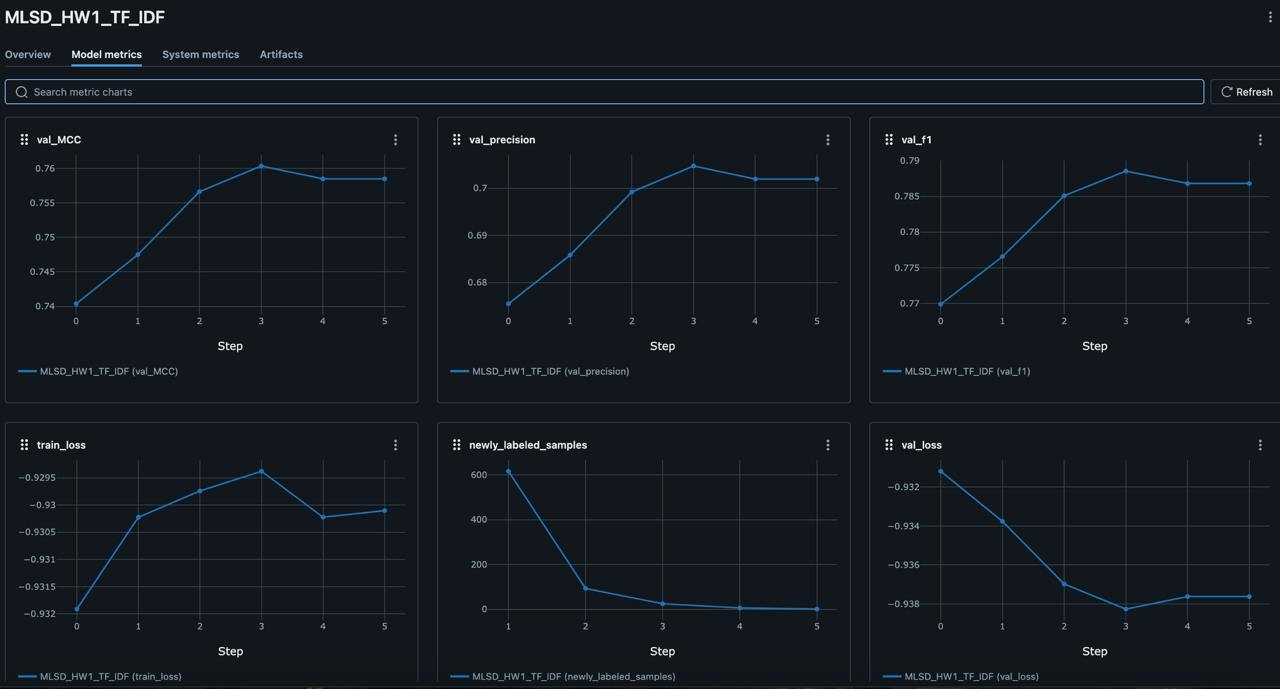

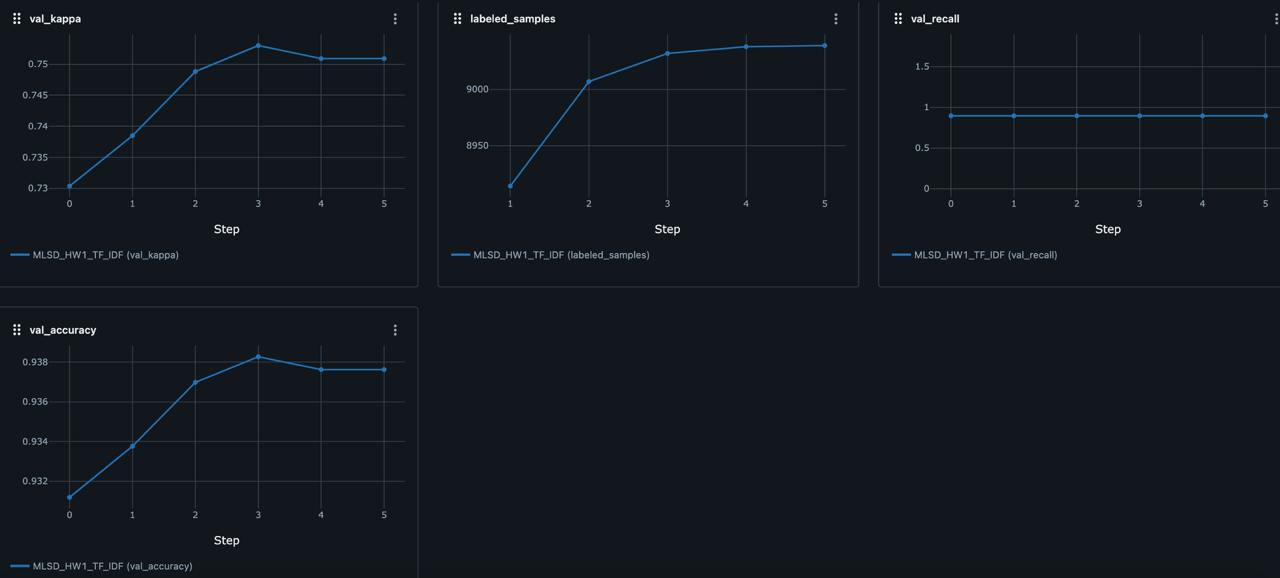

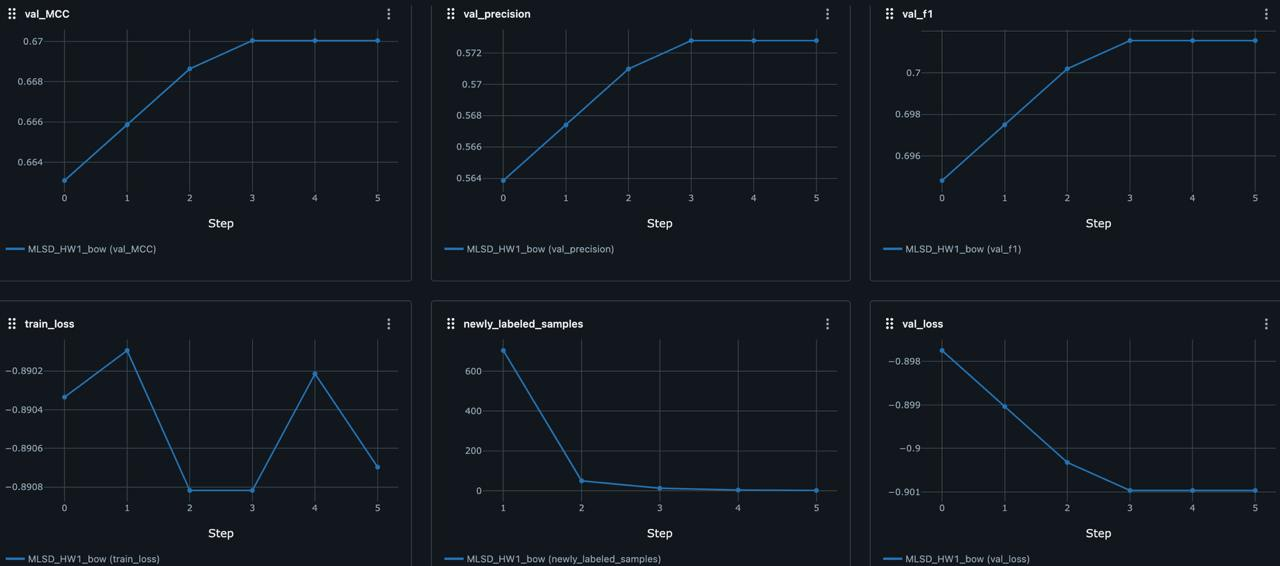

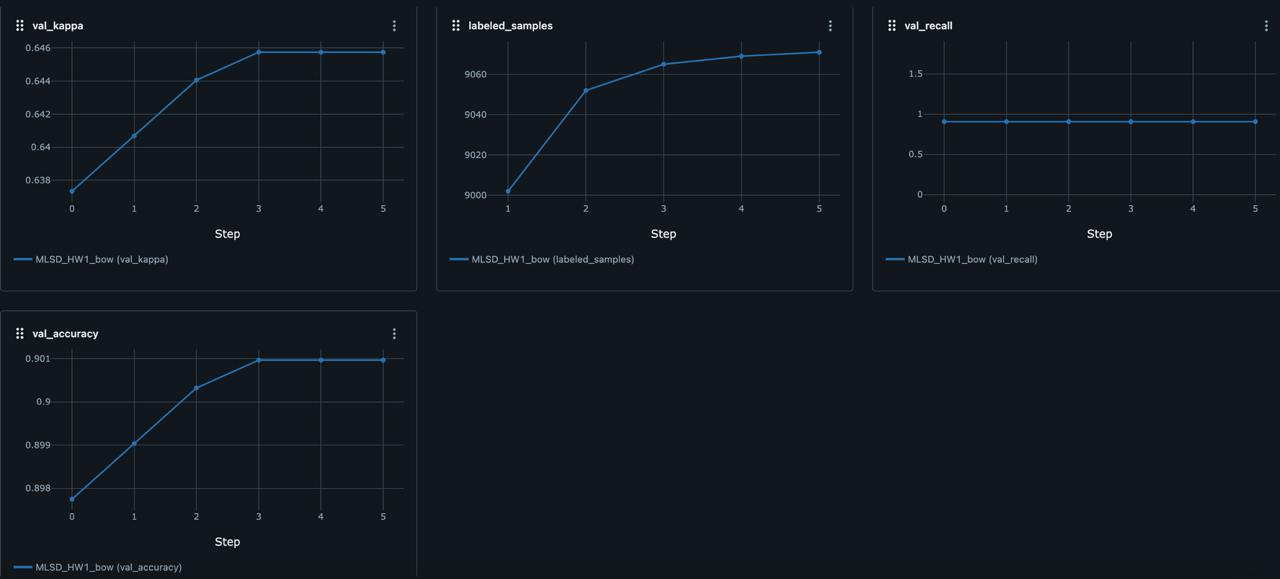

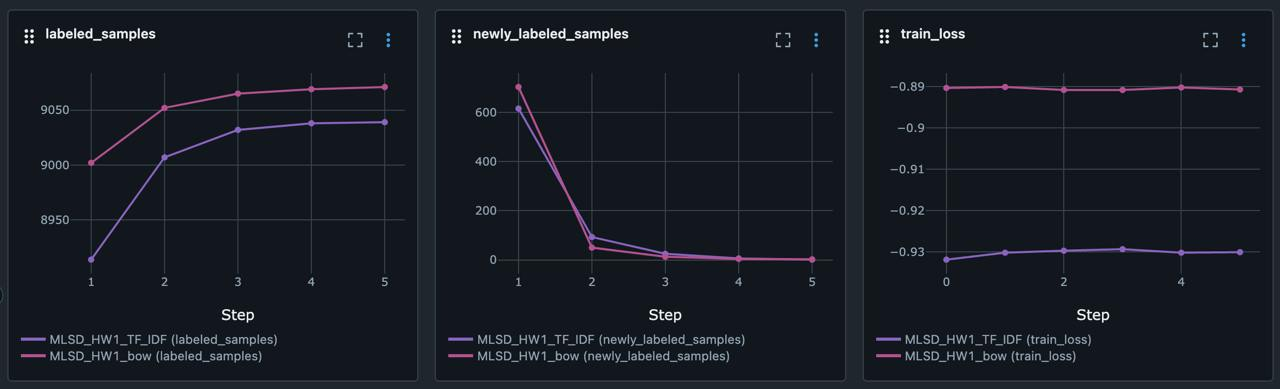

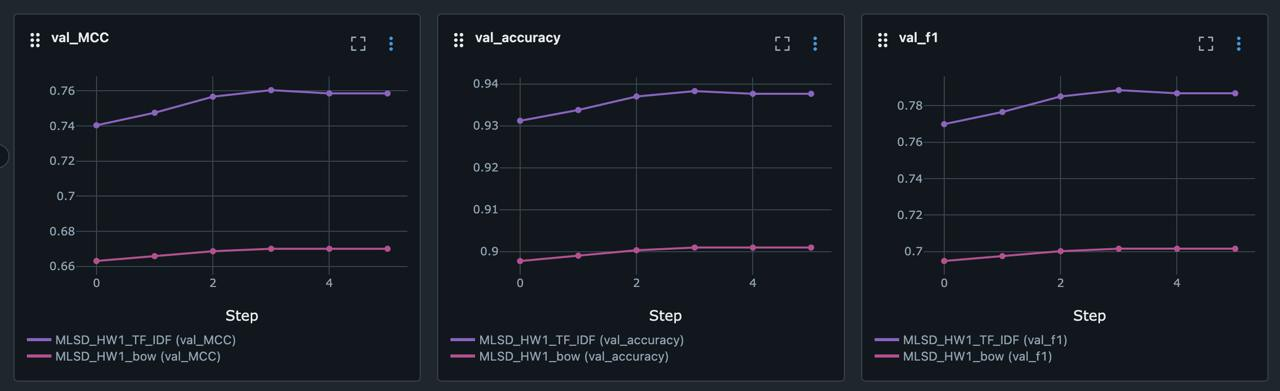

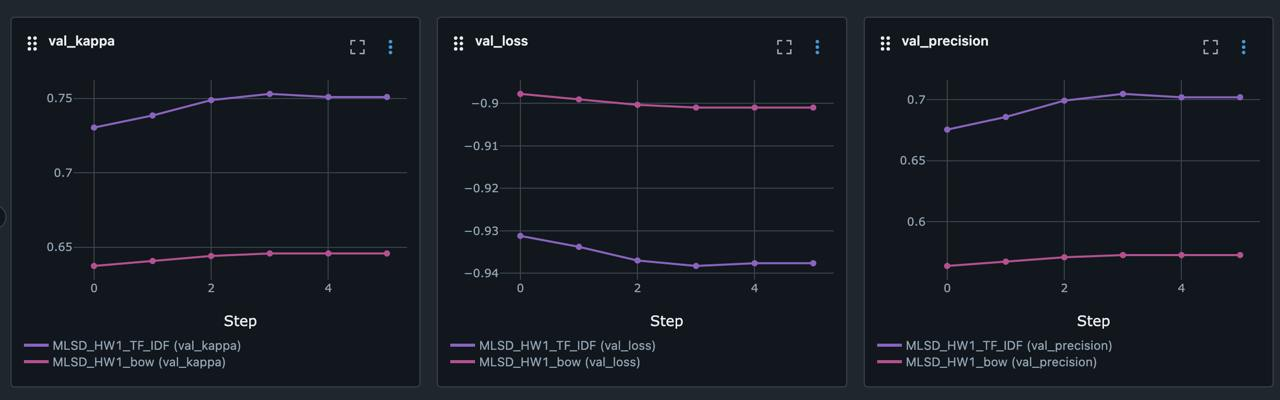